### Step 2.2.2 and  2.2.3


In [0]:
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

from scipy.stats import norm

import keras
from keras import layers
from keras.models import Model
from keras import metrics
from keras import backend as K   # 'generic' backend so code works with either tensorflow or theano

from scipy.stats import norm
from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D

K.clear_session()

np.random.seed(514)

Using TensorFlow backend.


### B. Combine Train & Test


In [0]:
from google.colab import drive
drive.mount('/content/drive')

os.chdir('/content/drive/My Drive/digit-recognizer') # Google CoLab


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
train_orig = pd.read_csv('./train.csv')
test_orig = pd.read_csv('./test.csv')

train_orig.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
# create 'label' column in test dataset; rearrange so that columns are in the same order as in train
test_orig['label'] = 11
testCols = test_orig.columns.tolist()
testCols = testCols[-1:] + testCols[:-1]
test_orig = test_orig[testCols]

In [0]:
combined = pd.concat([train_orig, test_orig], ignore_index = True)

combined.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
def plot_3D_normal(mu_x,variance_x,mu_y,variance_y,title):
  x = np.linspace(-10,10,500)
  y = np.linspace(-10,10,500)
  X, Y = np.meshgrid(x,y)
  pos = np.empty(X.shape + (2,))
  pos[:, :, 0] = X; pos[:, :, 1] = Y
  rv = multivariate_normal([mu_x, mu_y], [[variance_x, 0], [0, variance_y]])

  #Make a 3D plot
  fig = plt.figure(figsize=(10,10))
  ax = fig.gca(projection='3d')
  ax.plot_surface(X, Y, rv.pdf(pos),cmap='viridis',linewidth=0)
  ax.set_xlabel('X axis')
  ax.set_ylabel('Y axis')
  ax.set_zlabel('Z axis')
  plt.title(title)
  plt.show()

### spliting into training & validation sets

In [0]:
valid = combined.sample(n = 5000, random_state = 514)
train = combined.loc[~combined.index.isin(valid.index)]

# free up some space and delete test and combined
del train_orig, test_orig

valid.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
36162,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
32554,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
30302,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
50553,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
15062,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
valid.index

Int64Index([36162, 32554, 30302, 50553, 15062, 39438, 66966,  4320,  1758,
            25921,
            ...
            21349, 64795, 20453, 46719, 41092, 36327, 32042, 41863, 13288,
            54514],
           dtype='int64', length=5000)

### 2. Reshape & Normalize


In [0]:
# X's
X_train = train.drop(['label'], axis = 1)
X_valid = valid.drop(['label'], axis = 1)

# labels
y_train = train['label']
y_valid = valid['label']

# Normalize and reshape
X_train = X_train.astype('float32') / 255.
X_train = X_train.values.reshape(-1,28,28,1)

X_valid = X_valid.astype('float32') / 255.
X_valid = X_valid.values.reshape(-1,28,28,1)

# Isolate original training set records in validation set
valid_noTest = valid[valid['label'] != 11]

# X's and Y's
X_valid_noTest = valid_noTest.drop('label', axis=1)
y_valid_noTest = valid_noTest['label']

# Reshape and normalize
X_valid_noTest = X_valid_noTest.astype('float32') / 255.
X_valid_noTest = X_valid_noTest.values.reshape(-1,28,28,1)

Look at few random images.

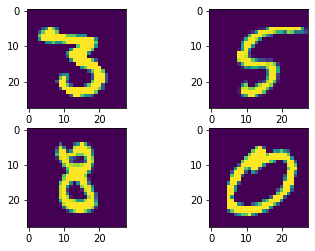

In [0]:
plt.figure(1)
plt.subplot(221)
plt.imshow(X_train[13][:,:,0])

plt.subplot(222)
plt.imshow(X_train[690][:,:,0])

plt.subplot(223)
plt.imshow(X_train[2375][:,:,0])

plt.subplot(224)
plt.imshow(X_train[42013][:,:,0])
plt.show()

### 3. Model Construction

### Encoder Network

In [0]:
img_shape = (28, 28, 1)    # for MNIST
batch_size = 16
latent_dim = 2  # Number of latent dimension parameters

In [0]:
# Encoder architecture: Input -> Conv2D*4 -> Flatten -> Dense
input_img = keras.Input(shape=img_shape)

x = layers.Conv2D(32, 3,
                  padding='same', 
                  activation='relu')(input_img)
x = layers.Conv2D(64, 3,
                  padding='same', 
                  activation='relu',
                  strides=(2, 2))(x)
x = layers.Conv2D(64, 3,
                  padding='same', 
                  activation='relu')(x)
x = layers.Conv2D(64, 3,
                  padding='same', 
                  activation='relu')(x)
# need to know the shape of the network here for the decoder
shape_before_flattening = K.int_shape(x)

x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)

# Two outputs, latent mean and (log)variance
z_mu = layers.Dense(latent_dim)(x)
z_log_sigma = layers.Dense(latent_dim)(x)

B. Sampling function
Next, we create a function to sample from the distribution we just learned the parameters of. epsilon is a tensor of small random normal values. One of the assumptions underlying a VAE like this is that our data arose from a random process and is normally distributed in the latent space.

With Keras, everything has to be in a 'layer' to compile correctly. This goes for our sampling function. The Lambda layer wrapper let's us do this.


In [0]:
# sampling function

def sampling(args):
    z_mu, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mu)[0], latent_dim),
                              mean=0., stddev=1.)
    return z_mu + K.exp(z_log_sigma) * epsilon

# sample vector from the latent distribution
z = layers.Lambda(sampling)([z_mu, z_log_sigma])

C. Decoder network
The decoder is basically the encoder in reverse.

In [0]:
# decoder takes the latent distribution sample as input
decoder_input = layers.Input(K.int_shape(z)[1:])

# Expand to 784 total pixels
x = layers.Dense(np.prod(shape_before_flattening[1:]),
                 activation='relu')(decoder_input)

# reshape
x = layers.Reshape(shape_before_flattening[1:])(x)

# use Conv2DTranspose to reverse the conv layers from the encoder
x = layers.Conv2DTranspose(32, 3,
                           padding='same', 
                           activation='relu',
                           strides=(2, 2))(x)
x = layers.Conv2D(1, 3,
                  padding='same', 
                  activation='sigmoid')(x)

# decoder model statement
decoder = Model(decoder_input, x)

# apply the decoder to the sample from the latent distribution
z_decoded = decoder(z)

D. Loss
We need one more thing and that's something that will calculate the unique loss function the VAE requires. Recall that the VAE is trained using a loss function with two components:

'Reconstruction loss' - This is the cross-entropy describing the errors between the decoded samples from the latent distribution and the original inputs.
The Kullback-Liebler divergence between the latent distribution and the prior (this acts as a sort of regularization term).
We define a custom layer class that calculates the loss.

In [0]:
# construct a custom layer to calculate the loss
class CustomVariationalLayer(keras.layers.Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        # Reconstruction loss
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        # KL divergence
        kl_loss = -5e-4 * K.mean(1 + z_log_sigma - K.square(z_mu) - K.exp(z_log_sigma), axis=-1)
        return K.mean(xent_loss + kl_loss)

    # adds the custom loss to the class
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x

# apply the custom loss to the input images and the decoded latent distribution sample
y = CustomVariationalLayer()([input_img, z_decoded])


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Now we can instantiate the model and take a look at its summary.



In [0]:
# VAE model statement
vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)
vae.summary()


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_2[0][0]                   
___________________________________________________________________________________________

In [0]:
vae.fit(x=X_train, y=None,
        shuffle=True,
        epochs=3,
        batch_size=batch_size,
        validation_data=(X_valid, None))

Train on 65000 samples, validate on 5000 samples
Epoch 1/3
65000/65000 [==============================] - 56s 861us/step - loss: 0.2046 - val_loss: 0.1961
Epoch 2/3
65000/65000 [==============================] - 55s 839us/step - loss: 0.1930 - val_loss: 0.1925
Epoch 3/3
65000/65000 [==============================] - 53s 821us/step - loss: 0.1889 - val_loss: 0.1907


### directly model V

In [0]:
# change k = 1 when need direct model V1 

k=0
combined0 = combined.loc[combined['label']==k]
combined0.head()


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
valid = combined0.sample(n = 350, random_state = 514)
train = combined0.loc[~combined0.index.isin(valid.index)]

# free up some space and delete test and combined
# del combined

valid.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
4168,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
20979,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
41610,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
26560,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
39959,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
# X's
X_train = train.drop(['label'], axis = 1)
X_valid = valid.drop(['label'], axis = 1)

# labels
y_train = train['label']
y_valid = valid['label']

# Normalize and reshape
X_train = X_train.astype('float32') / 255.
X_train = X_train.values.reshape(-1,28,28,1)

X_valid = X_valid.astype('float32') / 255.
X_valid = X_valid.values.reshape(-1,28,28,1)

# X's
X_train = train.drop(['label'], axis = 1)
X_valid = valid.drop(['label'], axis = 1)

# labels
y_train = train['label']
y_valid = valid['label']

# Normalize and reshape
X_train = X_train.astype('float32') / 255.
X_train = X_train.values.reshape(-1,28,28,1)

X_valid = X_valid.astype('float32') / 255.
X_valid = X_valid.values.reshape(-1,28,28,1)



In [0]:
vae.fit(x=X_train, y=None,
        shuffle=True,
        epochs=7,
        batch_size=batch_size,
        validation_data=(X_valid, None))

Train on 3782 samples, validate on 350 samples
Epoch 1/7
3782/3782 [==============================] - 3s 861us/step - loss: 0.1931 - val_loss: 0.1875
Epoch 2/7
3782/3782 [==============================] - 3s 837us/step - loss: 0.1831 - val_loss: 0.1855
Epoch 3/7
3782/3782 [==============================] - 3s 827us/step - loss: 0.1820 - val_loss: 0.1844
Epoch 4/7
3782/3782 [==============================] - 3s 821us/step - loss: 0.1815 - val_loss: 0.1843
Epoch 5/7
3782/3782 [==============================] - 3s 827us/step - loss: 0.1810 - val_loss: 0.1837
Epoch 6/7
3782/3782 [==============================] - 3s 823us/step - loss: 0.1805 - val_loss: 0.1835
Epoch 7/7
3782/3782 [==============================] - 3s 827us/step - loss: 0.1801 - val_loss: 0.1819


In [0]:
d_mean_model = Model(input_img,z_mu)
mu_0 = d_mean_model.predict(X_valid_noTest)
d_std_model = Model(input_img,z_log_sigma)
std_0 = d_std_model.predict(X_valid_noTest)
var_0 = std_0**2

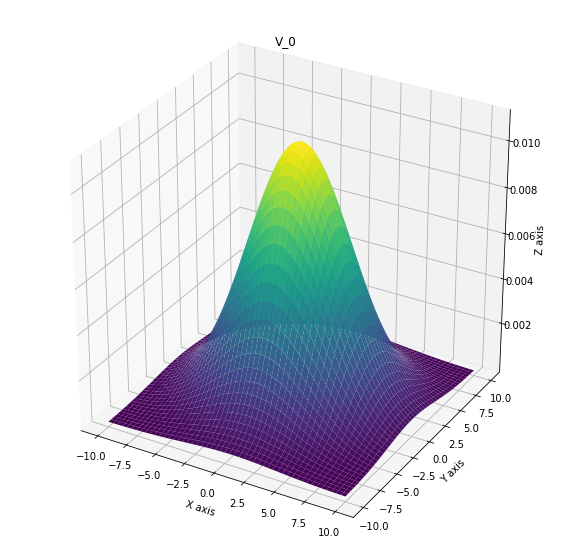

In [0]:
plot_3D_normal(np.mean(mu_0[:,0]),np.mean(var_0[:,0]),np.mean(mu_0[:,1]),np.mean(var_0[:,1]),title='V_0')

In [0]:
from random import randint
import random

random.seed(666)

rand = random.randint(0,500)
rand


233

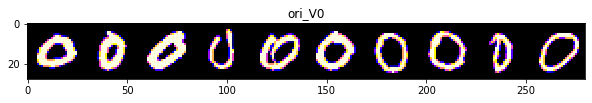

In [0]:
# original graph
digit_size = 28
figure = np.zeros((digit_size * 1, digit_size * 10))
traind = X_valid[rand:rand+10]

i = 0
for j in range(len(traind)):
    digit = traind[j][:,:,0]
    figure[i * digit_size: (i + 1) * digit_size,
          j * digit_size: (j + 1) * digit_size] = digit


plt.figure(figsize=(10, 10))
plt.title('ori_V0')
plt.imshow(figure, cmap='gnuplot2')
plt.show()



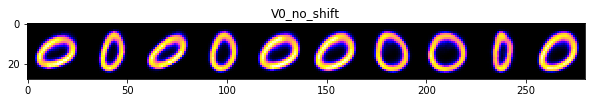

In [0]:
# original graph
digit_size = 28
figure = np.zeros((digit_size * 1, digit_size * 10))
traind = X_valid[rand:rand+10]

i = 0
for i in range(1):
  shifted_vector = x_train_encoded
# decode for each square in the grid
  for j in range(len(shifted_vector)):
    # for j, xi in enumerate(shifted_vector.transpose()[1]):
      z_sample = np.array([[shifted_vector[j][0], shifted_vector[j][1]]])
      z_sample = np.tile(z_sample, batch_size).reshape(batch_size, latent_dim)
      x_decoded = decoder.predict(z_sample, batch_size=batch_size)
      digit = x_decoded[0].reshape(digit_size, digit_size)
      figure[i * digit_size: (i + 1) * digit_size,j * digit_size: (j + 1) * digit_size] = digit


plt.figure(figsize=(10, 10))
plt.title('V0_no_shift')
plt.imshow(figure, cmap='gnuplot2')
plt.show()


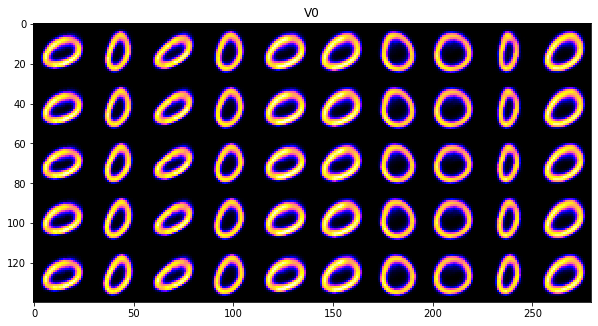

In [0]:
# generated graph

digit_size = 28
figure = np.zeros((digit_size * 5, digit_size * 10))


# def shift_image(index):
traind = X_valid[rand:rand+10]
encoder = Model(input_img, z_mu)
x_train_encoded = encoder.predict(traind, batch_size = batch_size)

for i in range(0,5):
  shifted_vector = x_train_encoded + (i+1)*0.05
# decode for each square in the grid
  for j in range(len(shifted_vector)):
    # for j, xi in enumerate(shifted_vector.transpose()[1]):
      z_sample = np.array([[shifted_vector[j][0], shifted_vector[j][1]]])
      z_sample = np.tile(z_sample, batch_size).reshape(batch_size, latent_dim)
      x_decoded = decoder.predict(z_sample, batch_size=batch_size)
      digit = x_decoded[0].reshape(digit_size, digit_size)
      figure[i * digit_size: (i + 1) * digit_size,
            j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.title('V0')
plt.imshow(figure, cmap='gnuplot2')
plt.show()

  # return(None)

    



### Step 2.2.3

In [0]:
from random import randint

# import the necessary packages
from skimage.measure import compare_ssim as ssim
import matplotlib.pyplot as plt
import numpy as np
import cv2

def f_mse(imageA, imageB):
	# the 'Mean Squared Error' between the two images is the
	# sum of the squared difference between the two images;
	# NOTE: the two images must have the same dimension
	err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
	err /= float(imageA.shape[0] * imageA.shape[1])
	
	# return the MSE, the lower the error, the more "similar"
	# the two images are
	return err
  

In [0]:
ssim_list = []
mse_list = []


for i in range(0,5):
  shifted_vector = x_train_encoded + (i+1)*0.05
  for j in range(len(shifted_vector)):
    z_sample = np.array([[shifted_vector[j][0],shifted_vector[j][1]]])
    z_sample = np.tile(z_sample,batch_size).reshape(batch_size, latent_dim)
    x_decoded = decoder.predict(z_sample, batch_size=batch_size)
    s = ssim(traind[j],x_decoded[j],multichannel=True)
    m = f_mse(traind[j],x_decoded[j])
    ssim_list.append(s)
    mse_list.append(m)

  mse = np.mean(mse_list)
  similarity = np.mean(ssim_list)

  print(f'i = {i+1}, similarity = {similarity}, mse = {mse}')
  print('-'*65)


i = 1, similarity = 0.7343404923256035, mse = 0.03644696104305745
-----------------------------------------------------------------
i = 2, similarity = 0.731560050008336, mse = 0.03684593891794448
-----------------------------------------------------------------
i = 3, similarity = 0.7274749145647389, mse = 0.03741094012216662
-----------------------------------------------------------------
i = 4, similarity = 0.722187307888358, mse = 0.03812564092964836
-----------------------------------------------------------------
i = 5, similarity = 0.7159752239770696, mse = 0.03897884870530405
-----------------------------------------------------------------
